# Weld Quality Classification Model - using Resnet transfer learning

In this notebook, we will evaluate five different ResNet transfer models (18, 34, 50, 101, and 152 layers) on our welding dataset.

This evaluation will include:
- **Overall Accuracy** giving us the percentage of correctly classified images.
- **Inference time** per variant, to compare speed vs. accuracy.
- **Actual vs. Predicted Images** in a bar chart.
- **Resnet 18 Misclassified Images** so we can see which images tripped up the 18 layer model.


## Setup

First we will import the libraries we need and define the device, load the test dataset, then setup the model for evaluation

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from collections import Counter
from PIL import Image
from pathlib import Path

%matplotlib inline 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device) 

# Here we will make sure all the images are 640x640, then convert them to tensors (which are like multidimensional arrays)
test_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])
print("transforms ready")  

data_dir = "Separated_Dataset" 
test_dir = os.path.join(data_dir, "test")

test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False) 
print(f"data loader ready — {len(test_loader)} batches")  
print("Test data size:", len(test_dataset))

# define variants and paths
variant_names = ["resnet18", "resnet34", "resnet50", "resnet101", "resnet152"]  
base_saved_dir = Path(r"C:\Users\gutte\OneDrive\Documents\School_2025\Capstone\WeldingPytorchModels\models\resnet_transfer_model\saved_models")  
print("variants to evaluate:", variant_names)  

Using device: cpu
transforms ready
data loader ready — 5 batches
Test data size: 36
variants to evaluate: ['resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152']


## Load Model

We instantiate each variant, freeze its pretrained layers, then load the saved weights, swap in our binary classification output layer, and set the model for evaluation. 

In [2]:
import torchvision.models as models

resnets = {}
for name in variant_names:
    # instantiate model  
    resnet = getattr(models, name)(weights=None)
    for param in resnet.parameters():
        param.requires_grad = False

    # replace original final connected layer with new one, 2 outputs (binary classification)
    in_features = resnet.fc.in_features
    resnet.fc    = nn.Linear(in_features, 2)

    resnet       = resnet.to(device)

    # load saved weights  
    model_path = base_saved_dir / name / "resnet_model.pth"
    if not model_path.exists():
        raise FileNotFoundError(f"{model_path} not found")
    resnet.load_state_dict(torch.load(model_path, map_location=device))
    resnet.eval()
    resnets[name] = resnet

    print(f"{name} loaded")  

print("=================\nall variants loaded")  

resnet18 loaded
resnet34 loaded
resnet50 loaded
resnet101 loaded
resnet152 loaded
all variants loaded


## Create Predictions

Now we run each model on all files in the test dataset, collecting predictions and measuring inference time. 

In [3]:
import time 

# gather true labels just once (not every test)
print("collecting true labels…")
all_labels = []
with torch.no_grad():
    for batch_idx, (_, labels) in enumerate(test_loader):
        all_labels.extend(labels.numpy())
print(f"collected {len(all_labels)} labels total")

# run inference for each variant and time it
all_preds = {}
inf_times = {} 

with torch.no_grad():
    for name, model in resnets.items():
        print(f"running inference for {name}…")
        start = time.time() 
        preds = []  
        for batch_idx, (images, _) in enumerate(test_loader):
            images = images.to(device) 
            outputs = model(images)
            _, p     = torch.max(outputs, 1) 
            preds.extend(p.cpu().numpy())
        elapsed = time.time() - start
        inf_times[name] = elapsed 
        all_preds[name] = preds
        print(f"finished {name} -> {len(preds)} preds in {elapsed:.2f}s")

print("run complete for all variants")

collecting true labels…
collected 36 labels total
running inference for resnet18…
finished resnet18 -> 36 preds in 4.00s
running inference for resnet34…
finished resnet34 -> 36 preds in 6.46s
running inference for resnet50…
finished resnet50 -> 36 preds in 12.40s
running inference for resnet101…
finished resnet101 -> 36 preds in 18.55s
running inference for resnet152…
finished resnet152 -> 36 preds in 25.75s
run complete for all variants


## Results
Below is a scatter plot showing accuracy and inference time by variant, plus a table and a bar chart depicting misclassification numbers. 

  variant  time_s (s)  accuracy (%)  correct  misclassified
 resnet18        4.00         86.11       31              5
 resnet34        6.46         86.11       31              5
 resnet50       12.40         88.89       32              4
resnet101       18.55         75.00       27              9
resnet152       25.75         88.89       32              4 



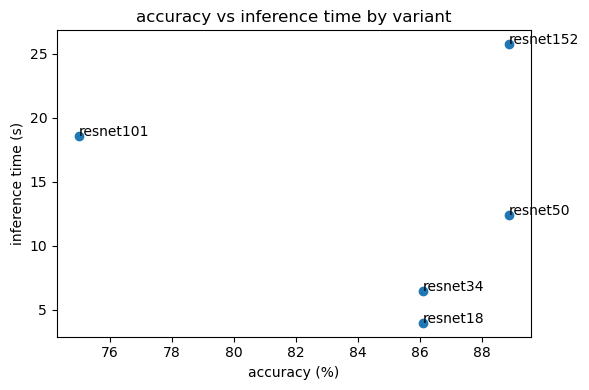

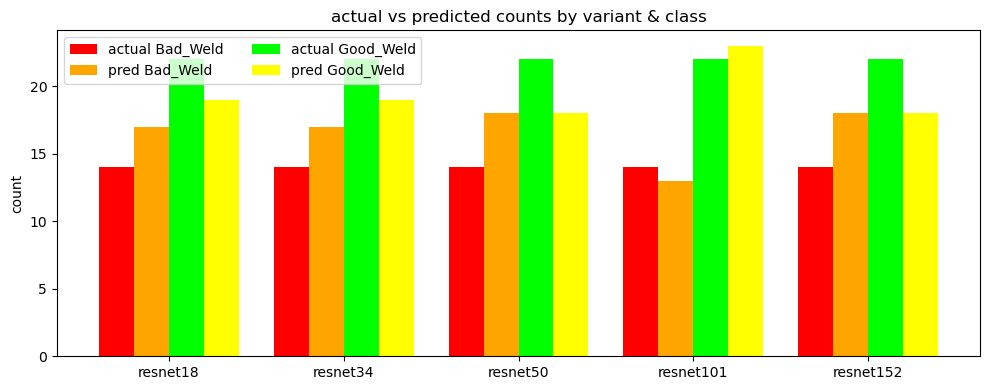

In [4]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

plt.close('all')

# build table for each variant
records = []
total   = len(all_labels)

for name in variant_names:
    preds       = all_preds[name]
    correct     = sum(p == a for p, a in zip(preds, all_labels))
    misclassified= total - correct
    accuracy    = 100.0 * correct / total
    time_s      = inf_times.get(name)
    
    records.append({
        "variant":      name,
        "time_s (s)":   round(time_s, 2),
        "accuracy (%)": round(accuracy, 2),
        "correct":      correct,
        "misclassified":misclassified
    })

summary_df = pd.DataFrame(records)
print(summary_df.to_string(index=False), "\n")

# scatter plot: accuracy vs inference time
fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(summary_df["accuracy (%)"], summary_df["time_s (s)"])

for _, r in summary_df.iterrows():
    ax.annotate(r["variant"], (r["accuracy (%)"], r["time_s (s)"]))

ax.set_xlabel("accuracy (%)")
ax.set_ylabel("inference time (s)")
ax.set_title("accuracy vs inference time by variant")
plt.tight_layout()
plt.show()


# actual vs predicted counts bar chart
class_names      = test_dataset.classes
cls_bad, cls_good = class_names

actual_counts = Counter([class_names[a] for a in all_labels])
pred_counts   = {
    name: Counter([class_names[p] for p in all_preds[name]])
    for name in variant_names
}

x  = np.arange(len(variant_names))
w  = 0.2

fig, ax = plt.subplots(figsize=(10,4))

# actual bad (red)
ax.bar(x - 1.5*w,
       [actual_counts[cls_bad]]*len(variant_names),
       w, label=f"actual {cls_bad}", color="#FF0000")

# pred bad (orange)
ax.bar(x - 0.5*w,
       [pred_counts[n][cls_bad] for n in variant_names],
       w, label=f"pred {cls_bad}",   color="#FFA500")

# actual good (green)
ax.bar(x + 0.5*w,
       [actual_counts[cls_good]]*len(variant_names),
       w, label=f"actual {cls_good}", color="#00FF00")

# pred good (yellow) 
ax.bar(x + 1.5*w,
       [pred_counts[n][cls_good] for n in variant_names],
       w, label=f"pred {cls_good}",   color="#FFFF00") 

ax.set_xticks(x) 
ax.set_xticklabels(variant_names) 
ax.set_ylabel("count") 
ax.set_title("actual vs predicted counts by variant & class")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()


## Resnet 18 Misclassified Image List

Finally, let's look at the images that were misclassified by the 18 layer model:

variant: resnet18
total images      : 36
correctly classified: 31
misclassified        : 5



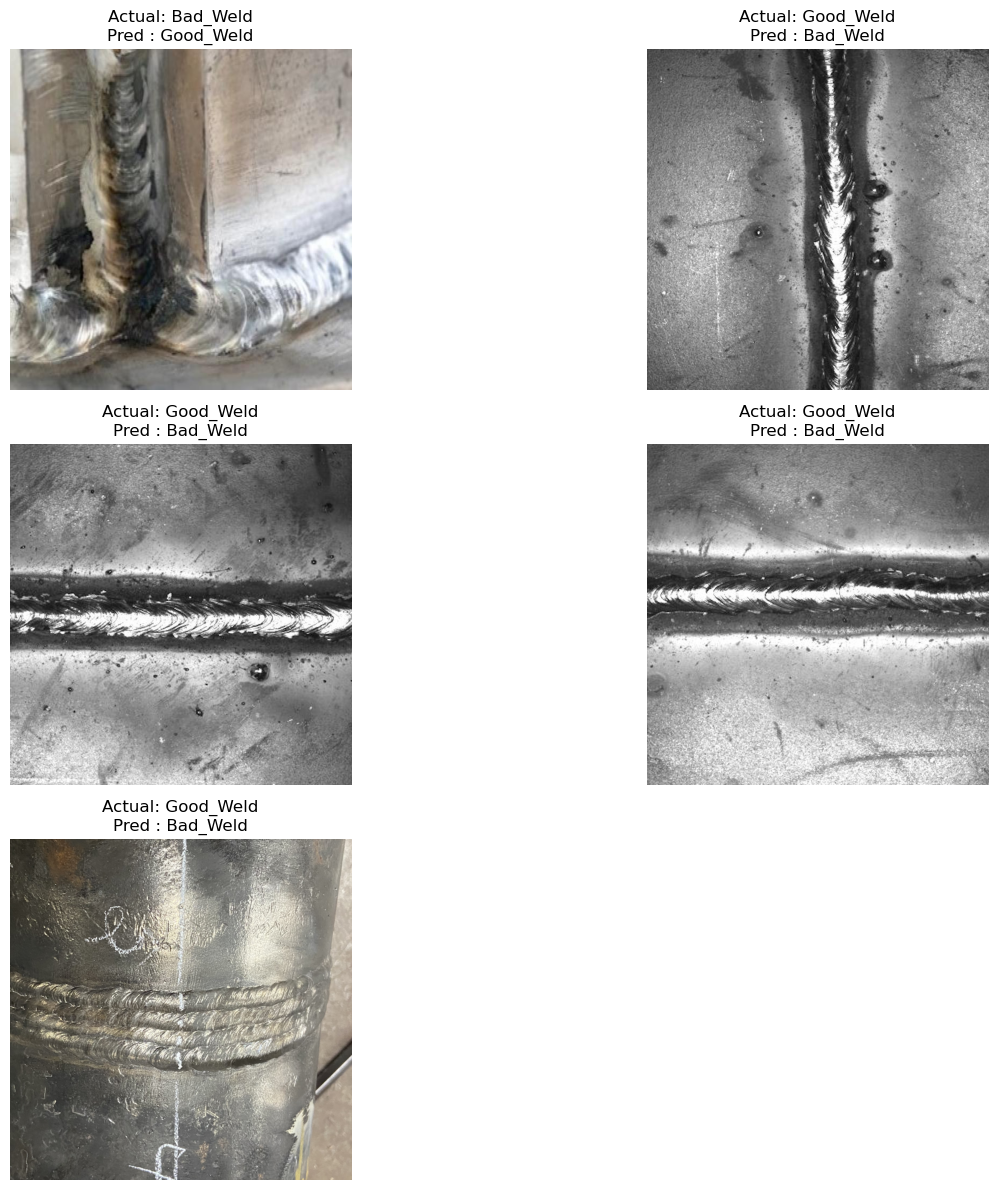

In [5]:
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import math

variant = "resnet18"
preds   = all_preds[variant]
total   = len(all_labels)
correct = sum(p == a for p,a in zip(preds, all_labels))
mis     = total - correct

print(f"variant: {variant}")
print(f"total images      : {total}")
print(f"correctly classified: {correct}")
print(f"misclassified        : {mis}\n")

misclassified = [(path, a, p) 
    for (path,a), p in zip(test_dataset.samples, preds) 
    if p != a]

n_cols = 2
n_rows = math.ceil(len(misclassified)/n_cols)
plt.figure(figsize=(14, n_rows*4))

for idx, (img_path, actual_idx, pred_idx) in enumerate(misclassified):
    img = Image.open(img_path).convert("RGB")
    plt.subplot(n_rows, n_cols, idx+1)
    plt.imshow(img)
    plt.title(f"Actual: {cls_bad if actual_idx==0 else cls_good}\n"
              f"Pred : {cls_bad if pred_idx==0  else cls_good}")
    plt.axis("off")

plt.tight_layout()
plt.show()